# Libraries to import :

https://www.youtube.com/watch?v=qFJeN9V1ZsI


https://deeplizard.com/learn/video/Zrt76AIbeh4

In [6]:
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
from contextlib import redirect_stdout

In [2]:
# for i in random.sample(glob.glob('train/cat*'),1000):
#     shutil.copy(i, 'data_template/cat')
# for i in random.sample(glob.glob('train/dog*'),1000):
#     shutil.copy(i, 'data_template/dog')                        

In [3]:
# for i in glob.glob('data_template/cat/*'): 
#     shutil.copy(i, 'data_template_tmp/cat')
# for i in glob.glob('data_template/dog/*'): 
#     shutil.copy(i, 'data_template_tmp/dog')

Define Classes for Polling Google Storage, Storing Model, and Sending Report

!!! Requires google service account key json file in current working directory

In [7]:
from google.cloud import storage  #must have google.cloud package installed
import os
import io
import time
import re
from zipfile import ZipFile
from pathlib import Path
import shutil
from datetime import datetime as dt
import smtplib, ssl
from email.message import EmailMessage
from email.mime.text import MIMEText
from email.mime.image import MIMEImage

In [11]:
class PollStorage:
    def __init__(self):
        self.email_add = None
        return
    
    def start_polling(self):
        #set google credentials and init google storage client
        os.environ['GOOGLE_APPLICATION_CREDENTIALS']="googleServiceAccountKey.json"
        client = storage.Client()
        blobList = []
        datasetName = ''
        #poll dataset bucket every n seconds to check for blobs
        while True:
            blobList = client.list_blobs("dataset-upload", prefix="dataset")
            for blob in blobList:
                datasetName = blob.name
                break
            if datasetName != '':
                break
            print('no files found in bucket')
            time.sleep(5)
    
        #get timestamp of file
        datasetTime = re.findall("[0-9]{6}", datasetName)[0]
        
        #get the corresponding email from email bucket and notify
        email_fname = 'emailToDeliver.txt'
        email_bucket = client.bucket('email-upload')
        email_blob = email_bucket.blob('email' + datasetTime + '.txt')
        email_blob.download_to_filename(email_fname)
        emailFile = open(email_fname, 'r')
        emailAddress = emailFile.readline()
        self.email_add = emailAddress
        emailFile.close()
        print('file was found, will send report to {} when finished processing'.format(emailAddress))
        
        #download dataset for processing
        extension = os.path.splitext(datasetName)[1]
        data_fname = 'dataset' + extension
        data_bucket = client.bucket('dataset-upload')
        data_blob = data_bucket.blob(datasetName)
        data_blob.download_to_filename(data_fname)
        print('dataset downloaded to {}, start processing'.format(data_fname))
        #delete email and dataset items in cloud storage
        email_blob.delete()
        data_blob.delete()
        print("email and data blobs deleted.")
        
        #delete any pre-existing directory data_template/
        dirPath = Path('data_template')
        if dirPath.exists() and dirPath.is_dir():
            shutil.rmtree(dirPath)
        
        #extract files from dataset.zip to data_template/
        with ZipFile(data_fname,'r') as zip_file:
            zip_file.extractall('data_template')
            
    def get_email(self):
        return self.email_add

In [9]:
class StoreModel:
    def __init__(self):
        self.model_link = None
        return
    def store_model(self, local_file):
        #set google credentials and init google storage client
        os.environ['GOOGLE_APPLICATION_CREDENTIALS']="googleServiceAccountKey.json"
        client = storage.Client()
        sourceFile = local_file
        destFile = 'model' + dt.now().strftime('%H%M%S') + '.h5'
        fileLink = 'https://storage.googleapis.com/stored-models/' + destFile
        #upload model file to google storage
        if self.upload_blob('stored-models', sourceFile, destFile):
            self.model_link = fileLink
        
    def upload_blob(self, bucket_name, source_file_name, destination_blob_name):
        """Uploads a file to the bucket."""
        # bucket_name = "bucket-name"
        # source_file_name = "local/path/to/file"
        # destination_blob_name = "storage-object-name"
    
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)
    
        blob.upload_from_filename(source_file_name)
    
        print(
            "File {} uploaded to {}.".format(
                source_file_name, destination_blob_name
            )
        )
        return True
    
    def get_model_link(self):
        return self.model_link

In [10]:
class SendReport:
    def __init__(self, model_link, email_add, cm_img, loss_img, acc_img, model_sum):
        self.model_link = model_link
        self.email_add = email_add
        self.cm_img = cm_img
        self.loss_img = loss_img
        self.acc_img = acc_img
        self.model_sum = model_sum
        
    def sendEmail(self):
        msg = EmailMessage()
        msg['Subject'] = 'Your trained and optimized model is ready'
        msg['From'] = "dlprojectnyu@gmail.com"
        msg['To'] = self.email_add
        
        #attach the model summary text file
        with open(self.model_sum, 'rb') as content_file:
            content = content_file.read()
            msg.add_attachment(content, maintype='application', subtype='txt', filename='model_summary.txt')
        #embed images of accuracy,loss,confMatrix in the email
        with open(self.acc_img, 'rb') as content_file:
            content = content_file.read()
            msgImage = MIMEImage(content)
            msgImage.add_header('Content-ID','<acc_image>')
            msg.attach(msgImage)
        with open(self.loss_img, 'rb') as content_file:
            content = content_file.read()
            msgImage = MIMEImage(content)
            msgImage.add_header('Content-ID','<loss_image>')
            msg.attach(msgImage)
        with open(self.cm_img, 'rb') as content_file:
            content = content_file.read()
            msgImage = MIMEImage(content)
            msgImage.add_header('Content-ID','<cm_image>')
            msg.attach(msgImage)
            
        
        #set body of email
        msgTextHeader = MIMEText('You can download your Keras model h5 file here: \n ' + self.model_link + '\n\n')
        msg.attach(msgTextHeader)
        #reference the images in the IMG SRC attribute by the IDs
        msgText = MIMEText('Report of your optimized model\'s performance in terms of accuracy, loss, and confusion matrix<br><br><br> \
            <img src="cid:acc_image"><br><br><img src="cid:loss_image"><br><br><img src="cid:cm_image"><br><br>','html')
        msg.attach(msgText)
        
        port = 465 #for SSL
        
        #create a secure SSL context
        context = ssl.create_default_context()
        password = 'Dlproject0!'
        with smtplib.SMTP_SSL("smtp.gmail.com", port, context=context) as server:
            server.login("dlprojectnyu@gmail.com", password)
            server.send_message(msg)
            server.quit()

### Poll Google Storage to find any user uploads

User can upload their dataset ZIP file via curl command in bash. <br>
User must specify their email address as a parameter in the embedded cloud function link seen below.  <br>
In this example, the user is uploading a ZIP file called 'userInput.zip' , but the file name can be anything.<br>
<br>
curl -X PUT -H 'Content-Type: application/octet-stream' --upload-file userInput.zip $(curl https://us-central1-dl-project-292616.cloudfunctions.net/uploadDatasetZIP?email=ewei485@gmail.com)


In [13]:
poll = PollStorage()
poll.start_polling()

no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
no files found in bucket
file was found, will send report to ewei485@gmail.com when finished processing
dataset downloaded to dataset.zip, start processing
email and data blobs deleted.


# I) Data template and data uniformisation

### Here,  we will get the input from the user and it will be stored in a folder : data_template.
### In this folder, we will have as many folders as classes for this particular task. 
### In this example, we are trying to classify cats vs dogs so therefore, we will have two folders inside data_template, 1 with dog images and the other one with cats images.
### From those class folders, we will prepare our training, validation and test folders containing themselves as many folders as classes.

In [24]:
# We have the template (i.e expected user's input) in a folder called data_template .

# Inside this folder, we have the different labels as folder with the images inside.


# First, let's store the number of classes of this particular dataset


list_labels = [re.sub("data_template/*",'',l) for l in glob.glob("data_template/*")]

for i in range(len(list_labels)):
    list_labels[i] = re.sub("[^a-zA-Z]","",list_labels[i])

print ("The labels are : " + str(list_labels))

# Check how many images per label (it will be useful later for class imbalance handling) and store that in a dictionary (also helpful for prepare train/valid/test)

labels_summary = {}
for lab in list_labels :
    to_add = {lab: len(os.listdir("data_template/"+lab+"/"))}
    labels_summary.update(to_add)
print(labels_summary)    

# Create directories for training/validation/testing

# We will have 3 new folders (training,validation,test) and each will contain subfolders one per label class





The labels are : ['cat', 'dog']
{'cat': 1000, 'dog': 1000}


In [5]:
# already done no need to run the following 

'''
for fold in ["training","validation","testing"]:
    for lab in list_labels :
        os.makedirs(fold+'/'+lab)

# # We will use shutils.move to move the data selected randomly to the corresponding folder
        
# # Take 70 % of the data for training from each class        
for lab in list_labels:
    for i in random.sample(glob.glob('data_template_tmp/'+lab+'/*'), int(labels_summary[lab]*0.7)):
        shutil.move(i, 'training/'+lab)  
        
# # Take 10 % of the data for validation from each class 
for lab in list_labels:
    for i in random.sample(glob.glob('data_template_tmp/'+lab+'/*'), int(labels_summary[lab]*0.1)):
        shutil.move(i, 'validation/'+lab)

# # Take the remaining 20% for testing
for lab in list_labels:
    for i in glob.glob('data_template_tmp/'+lab+'/*'):
        shutil.move(i, 'testing/'+lab)
'''  




# II) Prepare images to fit in the model

### Use image generator to prepare batches of images from the specified directory, specify the target size of the image. , the labels as well as the preprocessing techniques (the famous CNNs have their own preprocessing techniques).
### Importantly, we do not shuffle the test data to be able to report the metrics when we will do the predictions (y_pred vs y_true) so that we keep them in the same order.
### We specify an image size of 224*224 (pretty standard for images).

#  Different preprocessing of the input depending on which pretrained model with use and also if we create a model from scratch :

# a) Model from scratch data preprocessing : here we use the preprocessing from vgg16 as it is a standard one

In [25]:


batch_size=16

train_batches_from_scratch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) .flow_from_directory(directory="training/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
valid_batches_from_scratch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) .flow_from_directory(directory="validation/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
test_batches_from_scratch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) .flow_from_directory(directory="testing", target_size=(224,224), classes=list_labels, batch_size=batch_size, shuffle=False)


Found 1400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# Preselection  of top performing pre trained models 

# b) Pretrained model vgg16 data preprocessing :

In [26]:


batch_size=16

train_batches_vgg16 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) .flow_from_directory(directory="training/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
valid_batches_vgg16 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) .flow_from_directory(directory="validation/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
test_batches_vgg16 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) .flow_from_directory(directory="testing", target_size=(224,224), classes=list_labels, batch_size=batch_size, shuffle=False)


Found 1400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# c) Pretrained model MobileNet  data preprocessing :

In [27]:


batch_size=16

train_batches_mobilenet = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) .flow_from_directory(directory="training/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
valid_batches_mobilenet = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) .flow_from_directory(directory="validation/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
test_batches_mobilenet = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) .flow_from_directory(directory="testing", target_size=(224,224), classes=list_labels, batch_size=batch_size, shuffle=False)


Found 1400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# d) Pretrained model Inception  data preprocessing :

In [28]:


batch_size=16

train_batches_inception = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) .flow_from_directory(directory="training/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
valid_batches_inception = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) .flow_from_directory(directory="validation/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
test_batches_inception = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) .flow_from_directory(directory="testing", target_size=(224,224), classes=list_labels, batch_size=batch_size, shuffle=False)


Found 1400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# e) Pretrained model Inception ResNet v2  data preprocessing :

In [29]:


batch_size=16

train_batches_inception_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input) .flow_from_directory(directory="training/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
valid_batches_inception_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input) .flow_from_directory(directory="validation/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
test_batches_inception_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input) .flow_from_directory(directory="testing", target_size=(224,224), classes=list_labels, batch_size=batch_size, shuffle=False)


Found 1400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# f) Pretrained model Xception  data preprocessing :

In [30]:


batch_size=16

train_batches_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) .flow_from_directory(directory="training/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
valid_batches_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) .flow_from_directory(directory="validation/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
test_batches_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) .flow_from_directory(directory="testing", target_size=(224,224), classes=list_labels, batch_size=batch_size, shuffle=False)


Found 1400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# III) Prepare model architecture for the models  :

# Different models to try :



# a) First model is from scratch if dataset is very small :

In [31]:
model_from_scratch = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=len(list_labels), activation='softmax')   ## list_labels to adapt it to our own dataset for output
])
# Use state of the art optimizer to have a model that. already works well.
model_from_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_from_scratch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

In [13]:

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [32]:
n_epochs = 2
history_scratch = model_from_scratch.fit(x=train_batches_from_scratch,
    steps_per_epoch=len(train_batches_from_scratch),
    validation_data=valid_batches_from_scratch,
    validation_steps=len(valid_batches_from_scratch),
    epochs=n_epochs,
    verbose=1
)

Epoch 1/2
88/88 [==============================] - 87s 989ms/step - loss: 11.8413 - accuracy: 0.5679 - val_loss: 0.7038 - val_accuracy: 0.5000
Epoch 2/2
88/88 [==============================] - 85s 970ms/step - loss: 0.6750 - accuracy: 0.6107 - val_loss: 0.7422 - val_accuracy: 0.5400


# b) vgg16 :

### We will retrain the 2 fc layers and prediction layer for vgg16

In [33]:
n_epochs=2
vgg16 = tf.keras.applications.vgg16.VGG16() 
x = vgg16.layers[-2].output  # -2 misleading but basically. we remove the output. layer that we  replace with the following line
output = Dense(units=len(list_labels), activation='softmax')(x)
model_vgg16 = Model(inputs=vgg16.input, outputs=output)
for layer in model_vgg16.layers[:-3]:  # retrain fc1 , fc2 and prediction layer
    layer.trainable = False
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

history_vgg16 = model_vgg16.fit(x=train_batches_vgg16,
            validation_data=valid_batches_vgg16,
            validation_steps=len(valid_batches_vgg16),
            epochs=n_epochs,
            verbose=1
)



553467904/553467096 [==============================] - 1279s 2us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________

# c) Mobilenet  :

### We will remove last 6 layers and add output layer and freeze the layers 1 to N-5 to retrain only the last 5.

In [16]:
n_epochs=2
mobile = tf.keras.applications.mobilenet.MobileNet()
x = mobile.layers[-6].output # it has been shown that those last layers are learning task specific so we remove t hem
output = Dense(units=len(list_labels), activation='softmax')(x)
model_mobilenet = Model(inputs=mobile.input, outputs=output)
for layer in model_mobilenet.layers[:-5]:  ### retrain on those 5 layers
    layer.trainable = False
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet = model_mobilenet.fit(x=train_batches_mobilenet,
            steps_per_epoch=len(train_batches_mobilenet),
            validation_data=valid_batches_mobilenet,
            validation_steps=len(valid_batches_mobilenet),
            epochs=n_epochs,
            verbose=1
)

Epoch 1/2
88/88 [==============================] - 22s 253ms/step - loss: 0.1682 - accuracy: 0.9536 - val_loss: 0.2524 - val_accuracy: 0.9500
Epoch 2/2
88/88 [==============================] - 22s 250ms/step - loss: 0.0483 - accuracy: 0.9821 - val_loss: 0.1811 - val_accuracy: 0.9600


# d) Inception

In [17]:
n_epochs=2
inception = tf.keras.applications.inception_v3.InceptionV3()
x = inception.layers[-1].output # it has been shown that those last layers are learning task specific so we remove t hem
output = Dense(units=len(list_labels), activation='softmax')(x)
model_inception = Model(inputs=inception.input, outputs=output)
for layer in model_inception.layers[:-5]:  ### retrain on those 5 layers
    layer.trainable = False
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_inception = model_inception.fit(x=train_batches_inception,
            steps_per_epoch=len(train_batches_inception),
            validation_data=valid_batches_inception,
            validation_steps=len(valid_batches_inception),
            epochs=n_epochs,
            verbose=1
)

Epoch 1/2
88/88 [==============================] - 44s 496ms/step - loss: 0.6170 - accuracy: 0.9029 - val_loss: 0.5614 - val_accuracy: 0.9750
Epoch 2/2
88/88 [==============================] - 41s 469ms/step - loss: 0.5204 - accuracy: 0.9821 - val_loss: 0.4875 - val_accuracy: 0.9750


# e) Inception Resnet

In [18]:
n_epochs=2
inception_resnet = tf.keras.applications.inception_resnet_v2.InceptionResNetV2()
x = inception_resnet.layers[-1].output # it has been shown that those last layers are learning task specific so we remove t hem
output = Dense(units=len(list_labels), activation='softmax')(x)
model_inception_resnet = Model(inputs=inception_resnet.input, outputs=output)
for layer in model_inception_resnet.layers[:-5]:  ### retrain on those 5 layers
    layer.trainable = False
model_inception_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_inception_resnet = model_inception_resnet.fit(x=train_batches_inception_resnet,
            steps_per_epoch=len(train_batches_inception_resnet),
            validation_data=valid_batches_inception_resnet,
            validation_steps=len(valid_batches_inception_resnet),
            epochs=n_epochs,
            verbose=1
)

Epoch 1/2
88/88 [==============================] - 98s 1s/step - loss: 0.6115 - accuracy: 0.9243 - val_loss: 0.5436 - val_accuracy: 0.9850
Epoch 2/2
88/88 [==============================] - 97s 1s/step - loss: 0.4907 - accuracy: 0.9836 - val_loss: 0.4400 - val_accuracy: 0.9950


# f) Xception

In [19]:
n_epochs=2
xception = tf.keras.applications.xception.Xception()
x = xception.layers[-1].output # it has been shown that those last layers are learning task specific so we remove t hem
output = Dense(units=len(list_labels), activation='softmax')(x)
model_xception = Model(inputs=xception.input, outputs=output)
for layer in model_xception.layers[:-5]:  ### retrain on those 5 layers
    layer.trainable = False
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_xception = model_xception.fit(x=train_batches_inception,
            steps_per_epoch=len(train_batches_inception),
            validation_data=valid_batches_inception,
            validation_steps=len(valid_batches_inception),
            epochs=n_epochs,
            verbose=1
)

Epoch 1/2
88/88 [==============================] - 89s 1s/step - loss: 0.6271 - accuracy: 0.9364 - val_loss: 0.5653 - val_accuracy: 0.9850
Epoch 2/2
88/88 [==============================] - 87s 991ms/step - loss: 0.5140 - accuracy: 0.9743 - val_loss: 0.4651 - val_accuracy: 0.9750


# IV) Predictions and Report:
For each model :
- 3 plots : training history : loss and accuracy and confusion matrix on test (plots not nice because I only trained 2 epochs  just to make sure code works).
- saved model (.h5 file)
- model architecture (.txt file)

This will be stored in the user_output folder

In [35]:
def plot_confusion_matrix(cm, classes,name,
                          cmap=plt.cm.Blues,save=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)



    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save :
        plt.savefig("user_output/"+name)

In [36]:
def plot_history(history,name="",save=True):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if save:
        plt.savefig("user_output/"+name+"_loss.png")
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if save :
        plt.savefig("user_output/"+name+"_accuracy.png")


# a) Scratch

# Plots

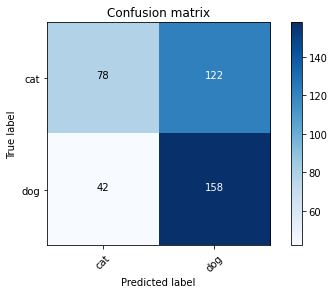

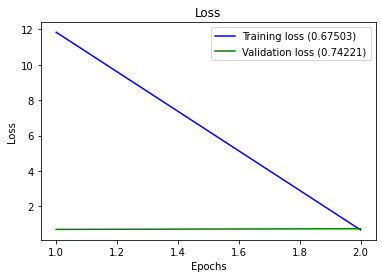

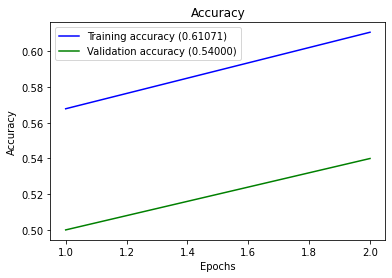

In [37]:
predictions_scratch = model_from_scratch.predict(x=test_batches_from_scratch, steps=len(test_batches_from_scratch), verbose=0) 
cm = confusion_matrix(y_true=test_batches_from_scratch.classes, y_pred=predictions_scratch.argmax(axis=1))


plot_confusion_matrix(cm=cm, classes=list(test_batches_from_scratch.class_indices.keys()),name="confusion_matrix_scratch.png")
plt.show()

plot_history(history_scratch,name="history_scratch")

plt.show()

# Saved model

In [49]:
model_from_scratch.save('user_output/model_scratch.h5') 

# Architecture

In [50]:
with open('user_output/model_scratch_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model_from_scratch.summary()

# b) vgg16

# Plots

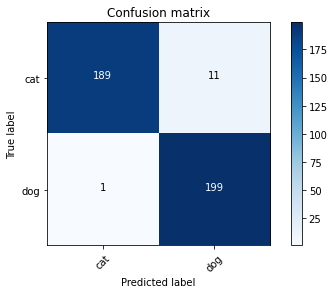

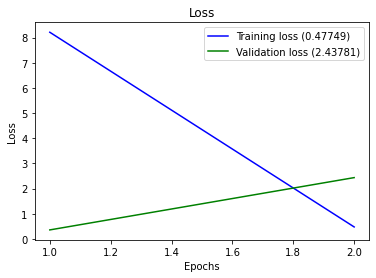

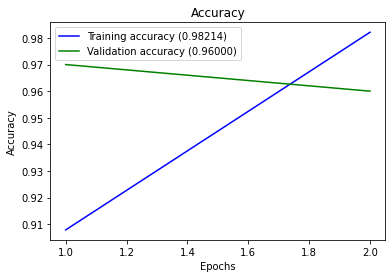

In [40]:
predictions_vgg16 = model_vgg16.predict(x=test_batches_vgg16, steps=len(test_batches_vgg16), verbose=0) 
cm = confusion_matrix(y_true=test_batches_vgg16.classes, y_pred=predictions_vgg16.argmax(axis=1))


plot_confusion_matrix(cm=cm, classes=list(test_batches_vgg16.class_indices.keys()),name="confusion_matrix_vgg16.png")
plt.show()

plot_history(history_vgg16,name="history_vgg16")

plt.show()

# Saved model

In [41]:
model_vgg16.save('user_output/model_vgg16.h5') 

# Architecture

In [42]:
with open('user_output/model_vgg16_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model_vgg16.summary()

# c) MobileNet

# Plots

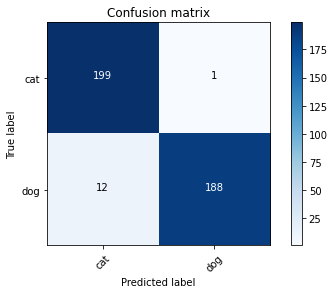

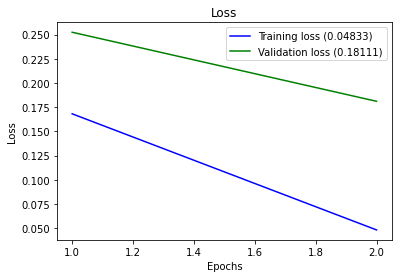

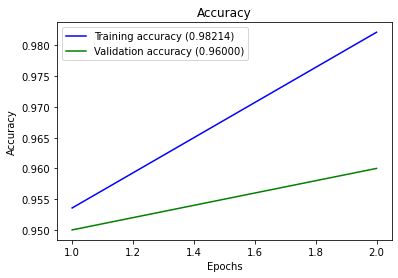

In [28]:
predictions_mobilenet = model_mobilenet.predict(x=test_batches_mobilenet, steps=len(test_batches_mobilenet), verbose=0) 
cm = confusion_matrix(y_true=test_batches_mobilenet.classes, y_pred=predictions_mobilenet.argmax(axis=1))


plot_confusion_matrix(cm=cm, classes=list(test_batches_mobilenet.class_indices.keys()),name="confusion_matrix_mobilenet.png")
plt.show()

plot_history(history_mobilenet,name="history_mobilenet")

plt.show()

# Saved model

In [29]:
model_mobilenet.save('user_output/model_mobilenet.h5') 

# Architecture

In [30]:
with open('user_output/model_mobilenet_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model_mobilenet.summary()

# d) Inception

# Plots

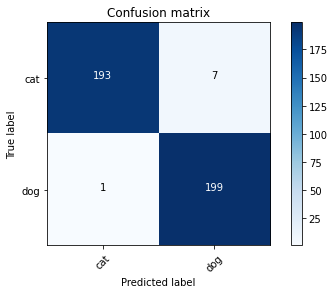

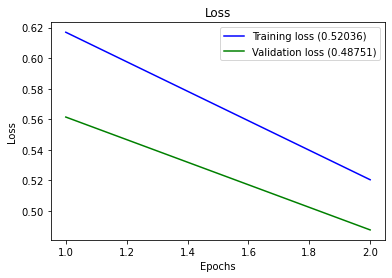

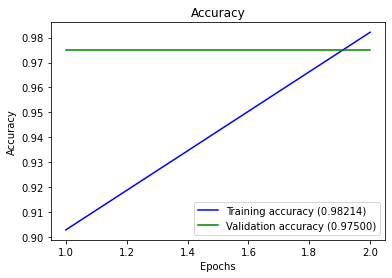

In [31]:
predictions_inception = model_inception.predict(x=test_batches_inception, steps=len(test_batches_inception), verbose=0) 
cm = confusion_matrix(y_true=test_batches_inception.classes, y_pred=predictions_inception.argmax(axis=1))


plot_confusion_matrix(cm=cm, classes=list(test_batches_inception.class_indices.keys()),name="confusion_matrix_inception.png")
plt.show()

plot_history(history_inception,name="history_inception")

plt.show()

# Saved model

In [32]:
model_inception.save('user_output/model_inception.h5') 

# Architecture

In [33]:


with open('user_output/model_inception_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model_inception.summary()

# e) Inception Resnet

# Plots

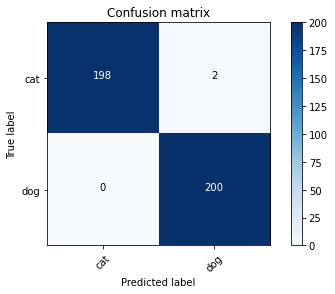

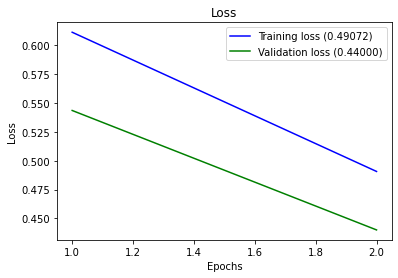

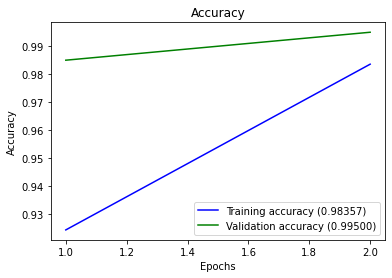

In [34]:
predictions_inception_resnet = model_inception_resnet.predict(x=test_batches_inception_resnet, steps=len(test_batches_inception_resnet), verbose=0) 
cm = confusion_matrix(y_true=test_batches_inception_resnet.classes, y_pred=predictions_inception_resnet.argmax(axis=1))


plot_confusion_matrix(cm=cm, classes=list(test_batches_inception_resnet.class_indices.keys()),name="confusion_matrix_inception_resnet.png")
plt.show()

plot_history(history_inception_resnet,name="history_inception_resnet")

plt.show()

# Saved model

In [35]:
model_inception_resnet.save('user_output/model_inception_resnet.h5') 

# Architecture

In [36]:


with open('user_output/model_inception_resnet_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model_inception_resnet.summary()

# f) Xception

# Plots

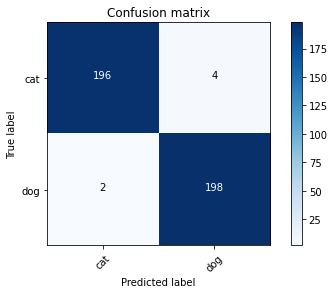

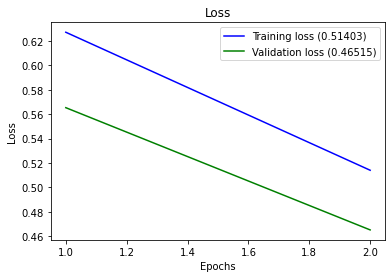

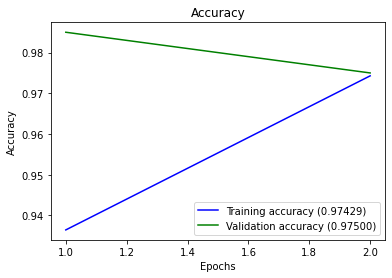

In [37]:
predictions_xception = model_xception.predict(x=test_batches_xception, steps=len(test_batches_xception), verbose=0) 
cm = confusion_matrix(y_true=test_batches_xception.classes, y_pred=predictions_xception.argmax(axis=1))


plot_confusion_matrix(cm=cm, classes=list(test_batches_xception.class_indices.keys()),name="confusion_matrix_xception.png")
plt.show()

plot_history(history_xception,name="history_xception")

plt.show()

# Saved model

In [38]:
model_from_scratch.save('user_output/model_xception.h5') 

# Architecture

In [39]:


with open('user_output/model_xception.txt', 'w') as f:
    with redirect_stdout(f):
        model_xception.summary()

 # PS : I didn't push .h5 files on github as they exceed limit size

Store best model h5 file in google storage

In [51]:
# used scratch as example. to be replaced in production use
best_model = 'scratch'

storeModel = StoreModel()
storeModel.store_model(local_file='user_output/model_' + best_model + '.h5')
print(storeModel.get_model_link())

File user_output/model_scratch.h5 uploaded to model145607.h5.
https://storage.googleapis.com/stored-models/model145607.h5


Send report to user

In [52]:
sendReport = SendReport(model_link=storeModel.get_model_link(),email_add=poll.get_email() \
                        ,cm_img='user_output/confusion_matrix_'+best_model+'.png' \
                        ,loss_img='user_output/history_'+best_model+'_loss.png' \
                        ,acc_img='user_output/history_'+best_model+'_accuracy.png' \
                        ,model_sum='user_output/model_'+best_model+'_summary.txt')
sendReport.sendEmail()